# Cantilever with a Tip Force

This example shows how to predict the behavior of a cantilever beam that is subjected
to a constant shear force at the tip.

![](../assets/tipforce-drawing.svg)

In [1]:
using GXBeam, LinearAlgebra

L = 1
EI = 1e6

# shear force (applied at end)
λ = 0:0.5:16
p = EI/L^2
P = λ*p

# create points
nelem = 16
x = range(0, L, length=nelem+1)
y = zero(x)
z = zero(x)
points = [[x[i],y[i],z[i]] for i = 1:length(x)]

# index of endpoints of each beam element
start = 1:nelem
stop = 2:nelem+1

# compliance matrix for each beam element
compliance = fill(Diagonal([0, 0, 0, 0, 1/EI, 0]), nelem)

# create assembly of interconnected nonlinear beams
assembly = Assembly(points, start, stop, compliance=compliance)

# pre-initialize system storage
system = System(assembly, true)

# run an analysis for each prescribed tip load
states = Vector{AssemblyState{Float64}}(undef, length(P))
for i = 1:length(P)

    # create dictionary of prescribed conditions
    prescribed_conditions = Dict(
        # fixed left side
        1 => PrescribedConditions(ux=0, uy=0, uz=0, theta_x=0, theta_y=0,
            theta_z=0),
        # shear force on right tip
        nelem+1 => PrescribedConditions(Fz = P[i])
    )

    # perform a static analysis
    static_analysis!(system, assembly;
        prescribed_conditions=prescribed_conditions)

    # post-process the results
    states[i] = AssemblyState(system, assembly;
        prescribed_conditions=prescribed_conditions)

end

nothing #hide

The analytical solution to this problem has been presented by several authors.  Here
we follow the solution by H. J. Barten in "On the Deflection of a Cantilever Beam",
after incorporating the corrections they submitted for finding the tip angle.

In [2]:
import Elliptic

δ = range(pi/4, pi/2, length=10^5)[2:end-1]

k = @. cos(pi/4)/sin(δ)
λ_a = @. (Elliptic.F(pi/2, k^2) - Elliptic.F(δ,  k^2))^2

θ_a = @. 2*(pi/4 - acos(k))

ξ_a = @. sqrt(2*sin(θ_a)/λ_a) .- 1

η_a = @. 1-2/sqrt(λ_a)*(Elliptic.E(pi/2, k^2) - Elliptic.E(δ, k^2))

nothing #hide

Plotting the results reveals that the analytical and computational solutions show
excellent agreement.

In [3]:
using Plots
pyplot()
nothing #hide

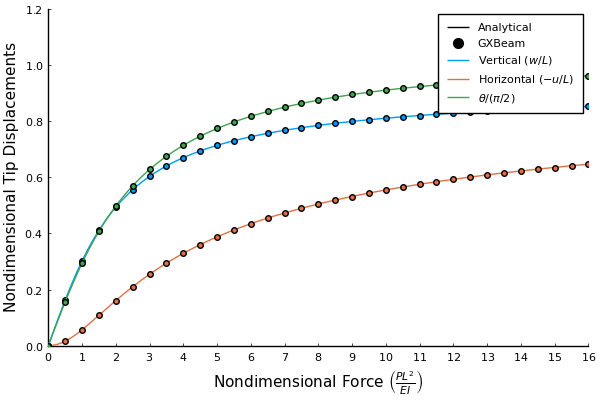

In [4]:
u = [states[i].points[end].u[1] for i = 1:length(P)]
θ = [states[i].points[end].theta[2] for i = 1:length(P)]
w = [states[i].points[end].u[3] for i = 1:length(P)]

# set up the plot
plot(
    xlim = (0, 16),
    xticks = 0:1:16,
    xlabel = "Nondimensional Force \$\\left(\\frac{PL^2}{EI}\\right)\$",
    ylim = (0, 1.2),
    yticks = 0.0:0.2:1.2,
    ylabel = "Nondimensional Tip Displacements",
    grid = false,
    overwrite_figure=false
    )

plot!([0], [0], color=:black, label="Analytical")
scatter!([0], [0], color=:black, label="GXBeam")
plot!([0], [0], color=1, label="Vertical \$\\left(w/L\\right)\$")
plot!([0], [0], color=2, label="Horizontal \$\\left(-u/L\\right)\$")
plot!([0], [0], color=3, label="\$ \\theta/(\\pi/2) \$")

plot!(λ_a, η_a, color=1, label="")
scatter!(λ, w/L, color=1, label="")

plot!(λ_a, -ξ_a, color=2, label="")
scatter!(λ, -u/L, color=2, label="")

plot!(λ_a, θ_a*2/pi, color=3, label="")
scatter!(λ, -4*atan.(θ/4)*2/pi, color=3, label="")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*